# Rally Stage Report for Dakar Rally

Generate a rally report for a single stage on the Dakar Rally, showing progression across splits.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import Dakar_Rally_2020 as dr

In [3]:
from Dakar_Rally_2020 import get_timing_data_long_timeInSplit, \
                                get_long_annotated_timing_data, TIME, RANK, \
                                rebaseWaypointTimes, pivotRebasedSplits, \
                                get_driver_data, cleanDriverSplitReportBaseDataframe, \
                                get_timing_data, insertColumn, moveColumn, \
                                get_ranking_data, getCurrPrevOverallRank

from dakar_utils import moreStyleDriverSplitReportBaseDataframe, \
                        sparkline2, sparklineStep, getTablePNG, pos1symbols
                                
import sqlite3
from sqlite_utils import Database
import pandas as pd

In [4]:
dbname = 'dakar_2020.db'

conn = sqlite3.connect(dbname)
db = Database(conn)

In [5]:
q="SELECT name FROM sqlite_master WHERE type = 'table';"
pd.read_sql(q, conn)

,name
0,teams
1,crew
2,vehicles
3,stagestats
4,ranking
5,waypoints


In [6]:
#VTYPE = 'car' # car moto


In [126]:
setups = {'sunderland':{'v':'moto','b':3},
          'alo':{'v':'car','b':310},
          'sainz':{'v':'car','b':305},
          'attiyah':{'v':'car', 'b':300},
          'price':{'v':'moto','b':1},
          'peterh':{'v':'car','b':302},
          'trucks':{'v':'truck','b':516},
          'sanz':{'v':'moto','b':14},
          'coronel':{'v':'car', 'b':347},
         }

def get_setup(n):
    return setups[n]['v'],setups[n]['b']

In [275]:
#REBASER = 310 #Alonso - 310, Sainz 305 #sunderland
CHART_POSITIONS = 10 #None for all


MAXMISSING = 10
if (CHART_POSITIONS / 2) < MAXMISSING:
    MAXMISSING = int(CHART_POSITIONS / 2)

In [334]:
STAGE = 12
VTYPE, REBASER = get_setup('trucks')
VTYPE, REBASER = get_setup('price')

In [335]:
def col_replacer(row, col, replace):
    return row[col].replace(row[replace],'').strip()

In [336]:
timing_data_long = get_long_annotated_timing_data(STAGE, VTYPE)[TIME]
timing_data_long_insplit = get_timing_data_long_timeInSplit(STAGE, VTYPE)
timing_data_long_min = rebaseWaypointTimes( timing_data_long , REBASER, 'TimeInS')
timing_data_long_min.head(3)

,Pos,Bib,Road Position,Refuel,Crew,Brand,Waypoint,Time,TimeInS,rebased
100,1,17,4.0,False,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,01_pk69,00:31:59,1919.0,-204.0
101,2,9,10.0,False,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,01_pk69,00:32:04,1924.0,-199.0
102,3,1,5.0,False,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,01_pk69,00:35:23,2123.0,0.0


In [337]:
rebaseWaypointTimes(timing_data_long_insplit,REBASER)

,Pos,Bib,Road Position,Refuel,Crew,Brand,Waypoint,Time,TimeInS,timeInSplit,splitS,rebased
100,1,17,4.0,False,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,01_pk69,00:31:59,1919.0,00:31:59,1919.0,-204.0
101,2,9,10.0,False,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,01_pk69,00:32:04,1924.0,00:32:04,1924.0,-199.0
102,3,1,5.0,False,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,01_pk69,00:35:23,2123.0,00:35:23,2123.0,0.0
104,5,5,1.0,False,P. QUINTANILLA ROCKSTAR ENERGY HUSQVARNA FACTO...,ROCKSTAR ENERGY HUSQVARNA FACTORY RACING,01_pk69,00:33:45,2025.0,00:33:45,2025.0,-98.0
105,6,7,9.0,False,K. BENAVIDES MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,01_pk69,00:35:07,2107.0,00:35:07,2107.0,-16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,96,103,93.5,False,G. SAGHMEISTER SAGHMEISTER TEAM,SAGHMEISTER TEAM,03_ass,02:36:04,9364.0,00:47:07,2827.0,1205.0
396,97,109,42.5,False,M. PAVAN NSM RACING TEAM,NSM RACING TEAM,03_ass,02:38:30,9510.0,00:56:43,3403.0,1781.0
397,98,88,95.5,False,J. ALVAREZ FERNANDEZ TEAM TIERRASTUR,TEAM TIERRASTUR,03_ass,02:45:24,9924.0,00:50:46,3046.0,1424.0
398,99,154,95.5,False,E. IGLESIAS SANCHEZ EDUARDO IGLESIAS SANCHEZ,EDUARDO IGLESIAS SANCHEZ,03_ass,02:45:26,9926.0,00:50:44,3044.0,1422.0


In [338]:
if REBASER:
    rb2c = pivotRebasedSplits(rebaseWaypointTimes(timing_data_long_insplit,REBASER))
else:
    rb2c = pivotRebasedSplits(rebaseWaypointTimes(timing_data_long_insplit,timing_data_long_insplit['Pos'].iloc[0]))
    
rb2c = cleanDriverSplitReportBaseDataframe(rb2c, STAGE)
top10 = get_driver_data(STAGE, CHART_POSITIONS, VTYPE)

#rb2cTop10 = rb2c[rb2c.index.isin(top10['Bib'])]
rb2cTop10 = pd.merge(top10, rb2c, how='left', left_index=True, right_index=True)
rb2cTop10.head(2)

,Pos,Road Position,Crew,Brand,D01_pk69,D02_pk119,D03_ass
Bib,,,,,,,
17,1,4.0,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,204.0,-60.0,1.0
9,2,10.0,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,199.0,-37.0,-70.0


In [339]:
#Need processing on the below - also change column order
newColOrder = rb2cTop10.columns[1:].tolist()+[rb2cTop10.columns[0]]
rb2cTop10=rb2cTop10[newColOrder]
rb2cTop10 = pd.merge(rb2cTop10, -timing_data_long_min.reset_index().pivot('Bib','Waypoint','rebased'),
                     how='left', left_index=True,right_index=True)


#Cast s to timedelta

#for c in [c for c in rb2cTop10.columns if c.startswith('0')]:
#    rb2cTop10[c]=rb2cTop10[c].apply(lambda x: pd.to_timedelta('{}00:00:{}'.format('-' if x<0 else '', '0' if pd.isnull(x) else abs(x))))

#Rename last column
rb2cTop10.rename(columns={rb2cTop10.columns[-1]:'Stage Overall'}, inplace=True)

rb2cTop10.dropna(how='all',axis=1,inplace=True)

#Drop very gappy waypoint cols
rb2cTop10.dropna(thresh=MAXMISSING,axis=1,inplace=True)

rb2cTop10#.head(3)

,Road Position,Crew,Brand,D01_pk69,D02_pk119,D03_ass,Pos,01_pk69,02_pk119,Stage Overall
Bib,,,,,,,,,,
17,4.0,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,204.0,-60.0,1.0,1,204.0,144.0,145.0
9,10.0,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,199.0,-37.0,-70.0,2,199.0,162.0,92.0
1,5.0,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,NaN,NaN,NaN,3,-0.0,-0.0,-0.0
16,3.0,L. BENAVIDES RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,NaN,-2189.0,22.0,4,NaN,-66.0,-44.0
5,1.0,P. QUINTANILLA ROCKSTAR ENERGY HUSQVARNA FACTO...,ROCKSTAR ENERGY HUSQVARNA FACTORY RACING,98.0,-46.0,-110.0,5,98.0,52.0,-58.0
7,9.0,K. BENAVIDES MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,16.0,-48.0,-56.0,6,16.0,-32.0,-88.0
11,17.0,A. METGE SHERCO TVS RALLY FACTORY,SHERCO TVS RALLY FACTORY,126.0,-154.0,-60.0,7,126.0,-28.0,-88.0
22,7.0,F. CAIMI MONSTER ENERGY YAMAHA RALLY TEAM,MONSTER ENERGY YAMAHA RALLY TEAM,119.0,-157.0,-71.0,8,119.0,-38.0,-109.0
35,16.0,M. GIEMZA ORLEN TEAM,ORLEN TEAM,155.0,-177.0,-106.0,9,155.0,-22.0,-128.0


In [340]:
from IPython.display import HTML

In [341]:
s2 = moreStyleDriverSplitReportBaseDataframe(rb2cTop10, STAGE)
display(HTML(s2))

,Road Position,Crew,Brand,D01_pk69,D02_pk119,D03_ass,Pos,01_pk69,02_pk119,Stage Overall
Bib,,,,,,,,,,
17,4,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,204,-60,1,1,204,144,145
9,10,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,199,-37,-70,2,199,162,92
1,5,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,0,0,0,3,-0,-0,-0
16,3,L. BENAVIDES RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,0,-2189,22,4,0,-66,-44
5,1,P. QUINTANILLA ROCKSTAR ENERGY HUSQVARNA FACTORY RACING,ROCKSTAR ENERGY HUSQVARNA FACTORY RACING,98,-46,-110,5,98,52,-58
7,9,K. BENAVIDES MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,16,-48,-56,6,16,-32,-88
11,17,A. METGE SHERCO TVS RALLY FACTORY,SHERCO TVS RALLY FACTORY,126,-154,-60,7,126,-28,-88
22,7,F. CAIMI MONSTER ENERGY YAMAHA RALLY TEAM,MONSTER ENERGY YAMAHA RALLY TEAM,119,-157,-71,8,119,-38,-109
35,16,M. GIEMZA ORLEN TEAM,ORLEN TEAM,155,-177,-106,9,155,-22,-128


In [342]:
rb2cTop10['test']= rb2cTop10[[c for c in rb2cTop10.columns if c.startswith(('0','1','Stage Overall'))]].values.tolist()
#Swap the sign of the values
rb2cTop10['test'] = rb2cTop10['test'].apply(lambda x: [-y for y in x])
rb2cTop10.head()

,Road Position,Crew,Brand,D01_pk69,D02_pk119,D03_ass,Pos,01_pk69,02_pk119,Stage Overall,test
Bib,,,,,,,,,,,
17,4.0,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,204.0,-60.0,1.0,1,204.0,144.0,145.0,"[-203.99999999999977, -144.0, -145.0]"
9,10.0,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,199.0,-37.0,-70.0,2,199.0,162.0,92.0,"[-198.99999999999977, -162.0, -92.0]"
1,5.0,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,NaN,NaN,NaN,3,-0.0,-0.0,-0.0,"[0.0, 0.0, 0.0]"
16,3.0,L. BENAVIDES RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,NaN,-2189.0,22.0,4,NaN,-66.0,-44.0,"[nan, 66.0, 44.0]"
5,1.0,P. QUINTANILLA ROCKSTAR ENERGY HUSQVARNA FACTO...,ROCKSTAR ENERGY HUSQVARNA FACTORY RACING,98.0,-46.0,-110.0,5,98.0,52.0,-58.0,"[-97.99999999999977, -52.0, 58.0]"


In [343]:
brandcol = rb2cTop10.columns.get_loc("Brand")
rb2cTop10.insert(brandcol+1, 'Stage Gap', rb2cTop10['test'].apply(sparkline2,typ='bar'))
rb2cTop10.drop('test', axis=1, inplace=True)
rb2cTop10.columns

Index(['Road Position', 'Crew', 'Brand', 'Stage Gap', 'D01_pk69', 'D02_pk119',
       'D03_ass', 'Pos', '01_pk69', '02_pk119', 'Stage Overall'],
      dtype='object')

In [344]:
display(HTML(rb2cTop10.head(3).style.render()))

,Road Position,Crew,Brand,Stage Gap,D01_pk69,D02_pk119,D03_ass,Pos,01_pk69,02_pk119,Stage Overall
Bib,,,,,,,,,,,
17,4,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAA10lEQVR4nO3bwQ2CQBRF0cG4sQQ7sAu6ogi6ogs6sASXWIEY5jlxSM7ZEuCT3AyQwLBt21ag0uXfA3BuAiIiICLXpkcfhqrdntNUXo9H3TnH8fO2Zak7ZmJvnlKqZ7qta7nPc9W%2B5YePvUPTh%2BjKgCJ7l9PbPKX0OdMBbmFEBEREQEQERERARAREREBEBEREQEQERERARAREREBEBEREQEQERERARNp%2B0tqbHv9g6nGmA6xARAREREBEBEREQEQERKTta/zJX1H5zgpEREBEBEREQEQEROQNXd0gP2PyyWIAAAAASUVORK5CYII%3D"" />",204,-60,1,1,204,144,145
9,10,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAA2ElEQVR4nO3awQ2CQBRF0cG4sQQ7oAu6ogi6ogs6sASXWIEY5zkR9JwtAb7JzTABu3Vd1wKVTt8egGMTEBEBETk3vXrXVZ12G8dy7/u6ew7D82PzXHfNxNY8pVTPdFmWcp2mqnPLB7e9XdNNdGVAka2fs7d5StnnTG/wCCMiICICIiIgIgIiIiAiAiIiICICIiIgIm2/hfHawf%2BOZQUiIiAiAiIiICICIiIgIgIiIiAi//Ui8eAv7fbICkREQEQERERARNpuom1af54ViIiAiAiIiICICIjIAyPQIEHQR4wfAAAAAElFTkSuQmCC"" />",199,-37,-70,2,199,162,92
1,5,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,,nan,nan,nan,3,-0,-0,-0


In [345]:
# get gap to leader at each split
tmp = get_timing_data(STAGE,vtype=VTYPE, timerank='gap', kind='full')[TIME].set_index('Bib')
tmp.dropna(thresh=MAXMISSING,axis=1,inplace=True)
tmp.head(3)

,Pos,Refuel,Crew,Brand,00_dss,01_pk69,02_pk119,03_ass,dss_gain_00,dss_pos_00,dss_raw_00,pk69_gain_01,pk69_pos_01,pk69_raw_01,pk119_gain_02,pk119_pos_02,pk119_raw_02,ass_gain_03,ass_raw_03
Bib,,,,,,,,,,,,,,,,,,,
17,1,False,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,07:34:00,00:00:00,00:00:18,00:00:00,=,4.0,07:34:00,▲,1.0,00:00:00,▼,2.0,00:00:18,▲,00:00:00
9,2,False,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,07:52:00,00:00:05,00:00:00,00:00:53,=,10.0,07:52:00,▲,2.0,00:00:05,▲,1.0,00:00:00,▼,00:00:53
1,3,False,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,07:37:00,00:03:24,00:02:42,00:02:25,=,5.0,07:37:00,▼,19.0,00:03:24,▲,4.0,00:02:42,▲,00:02:25


In [346]:
cols = [c for c in tmp.columns if c.startswith(('0','1'))]
tmp[cols]  = tmp[cols].apply(lambda x: x.dt.total_seconds())
tmp['test']= tmp[[c for c in tmp.columns if (c.startswith(('0','1')) and 'dss' not in c)]].values.tolist()
tmp['test2']= tmp[[c for c in tmp.columns if '_pos' in c]+['Pos']].values.tolist()
#Want better rank higher up
tmp['test2'] = tmp['test2'].apply(lambda x: [-y for y in x])
tmp.head(3)


,Pos,Refuel,Crew,Brand,00_dss,01_pk69,02_pk119,03_ass,dss_gain_00,dss_pos_00,...,pk69_gain_01,pk69_pos_01,pk69_raw_01,pk119_gain_02,pk119_pos_02,pk119_raw_02,ass_gain_03,ass_raw_03,test,test2
Bib,,,,,,,,,,,,,,,,,,,,,
17,1,False,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,27240.0,0.0,18.0,0.0,=,4.0,...,▲,1.0,00:00:00,▼,2.0,00:00:18,▲,00:00:00,"[0.0, 18.0, 0.0]","[-4.0, -1.0, -2.0, -1.0]"
9,2,False,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,28320.0,5.0,0.0,53.0,=,10.0,...,▲,2.0,00:00:05,▲,1.0,00:00:00,▼,00:00:53,"[5.0, 0.0, 53.0]","[-10.0, -2.0, -1.0, -2.0]"
1,3,False,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,27420.0,204.0,162.0,145.0,=,5.0,...,▼,19.0,00:03:24,▲,4.0,00:02:42,▲,00:02:25,"[204.0, 162.0, 145.0]","[-5.0, -19.0, -4.0, -3.0]"


In [347]:
rb3c = get_timing_data(STAGE,vtype=VTYPE, timerank='gap', kind='full')[TIME].set_index('Bib')
rb3c.dropna(thresh=MAXMISSING,axis=1,inplace=True)
rb3c.head(3)

,Pos,Refuel,Crew,Brand,00_dss,01_pk69,02_pk119,03_ass,dss_gain_00,dss_pos_00,dss_raw_00,pk69_gain_01,pk69_pos_01,pk69_raw_01,pk119_gain_02,pk119_pos_02,pk119_raw_02,ass_gain_03,ass_raw_03
Bib,,,,,,,,,,,,,,,,,,,
17,1,False,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,07:34:00,00:00:00,00:00:18,00:00:00,=,4.0,07:34:00,▲,1.0,00:00:00,▼,2.0,00:00:18,▲,00:00:00
9,2,False,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,07:52:00,00:00:05,00:00:00,00:00:53,=,10.0,07:52:00,▲,2.0,00:00:05,▲,1.0,00:00:00,▼,00:00:53
1,3,False,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,07:37:00,00:03:24,00:02:42,00:02:25,=,5.0,07:37:00,▼,19.0,00:03:24,▲,4.0,00:02:42,▲,00:02:25


In [348]:
rb3cTop10 = pd.merge(rb2cTop10[[]], rb3c, how='left', left_index=True,right_index=True)

cols = [c for c in rb3cTop10.columns if c.startswith(('0','1'))]
#rb2cTop10[cols]  = rb2cTop10[cols].apply(lambda x: x.dt.total_seconds())

rb3cTop10['test2']= rb3cTop10[[c for c in rb3cTop10.columns if ('_pos' in c and 'dss' not in c)]+['Pos']].values.tolist()
#Want better rank higher up
rb3cTop10['test2'] = rb3cTop10['test2'].apply(lambda x: [-y if not pd.isnull(y) else float('NaN') for y in x ])
rb3cTop10['Waypoint Rank'] = rb3cTop10['test2'].apply(sparklineStep,figsize=(0.5, 0.5))
rb3cTop10.head(3)

,Pos,Refuel,Crew,Brand,00_dss,01_pk69,02_pk119,03_ass,dss_gain_00,dss_pos_00,...,pk69_gain_01,pk69_pos_01,pk69_raw_01,pk119_gain_02,pk119_pos_02,pk119_raw_02,ass_gain_03,ass_raw_03,test2,Waypoint Rank
Bib,,,,,,,,,,,,,,,,,,,,,
17,1,False,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,07:34:00,00:00:00,00:00:18,00:00:00,=,4.0,...,▲,1.0,00:00:00,▼,2.0,00:00:18,▲,00:00:00,"[-1.0, -2.0, -1.0]","<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
9,2,False,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,07:52:00,00:00:05,00:00:00,00:00:53,=,10.0,...,▲,2.0,00:00:05,▲,1.0,00:00:00,▼,00:00:53,"[-2.0, -1.0, -2.0]","<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
1,3,False,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,07:37:00,00:03:24,00:02:42,00:02:25,=,5.0,...,▼,19.0,00:03:24,▲,4.0,00:02:42,▲,00:02:25,"[-19.0, -4.0, -3.0]","<img src=""data:image/png;base64,iVBORw0KGgoAAA..."


In [349]:
rb3cTop10['test2'].head(3)

Bib
17     [-1.0, -2.0, -1.0]
9      [-2.0, -1.0, -2.0]
1     [-19.0, -4.0, -3.0]
Name: test2, dtype: object

In [350]:
rb3cTop10['test2'].apply(pos1symbols)

Bib
17    [T, F, T]
9     [F, T, F]
1     [F, F, F]
16    [F, F, F]
5     [F, F, F]
7     [F, F, F]
11    [F, F, F]
22    [F, F, F]
35    [F, F, F]
6     [F, F, F]
Name: test2, dtype: object

In [351]:
#Use a copy for nw, while testing
rb4cTop10 = rb2cTop10.copy()
rb4cTop10.columns

Index(['Road Position', 'Crew', 'Brand', 'Stage Gap', 'D01_pk69', 'D02_pk119',
       'D03_ass', 'Pos', '01_pk69', '02_pk119', 'Stage Overall'],
      dtype='object')

In [352]:
#Create line chart for pos between each waypoint
q=f"SELECT Bib, WaypointOrder, WaypointPos FROM waypoints WHERE VehicleType='{VTYPE}' AND Stage={STAGE};"
tmp = pd.read_sql(q, conn).pivot(index='Bib',
                                 columns='WaypointOrder',
                                 values='WaypointPos')
tmp.dropna(thresh=MAXMISSING,axis=1,inplace=True)
tmp['waypos'] = tmp.values.tolist()
tmp['waypos'] = tmp['waypos'].apply(lambda x: [-y if not pd.isnull(y) else float('NaN') for y in x ])
tmp['waypos']

Bib
1        [-19.0, -1.0, -4.0]
2         [nan, -95.0, -2.0]
5        [-9.0, -3.0, -17.0]
6       [-14.0, -6.0, -18.0]
7        [-17.0, -4.0, -6.0]
               ...          
145    [-76.0, -78.0, -79.0]
152    [-42.0, -46.0, -48.0]
154    [-92.0, -93.0, -94.0]
155    [-89.0, -88.0, -92.0]
158    [-60.0, -58.0, -65.0]
Name: waypos, Length: 100, dtype: object

In [353]:
tmp['Waypoint Pos'] = tmp['waypos'].apply(sparklineStep,figsize=(0.5, 0.5))
insertColumn(rb4cTop10, 'Waypoint Pos', tmp['Waypoint Pos'], right_of='Brand')

In [354]:
rb3cTop10.columns

Index(['Pos', 'Refuel', 'Crew', 'Brand', '00_dss', '01_pk69', '02_pk119',
       '03_ass', 'dss_gain_00', 'dss_pos_00', 'dss_raw_00', 'pk69_gain_01',
       'pk69_pos_01', 'pk69_raw_01', 'pk119_gain_02', 'pk119_pos_02',
       'pk119_raw_02', 'ass_gain_03', 'ass_raw_03', 'test2', 'Waypoint Rank'],
      dtype='object')

In [355]:
#Get rid of NA cols - maybe do this on a threshold?
rb3cTop10.dropna(how='all',axis=1,inplace=True)

rb3cTop10['test']= rb3cTop10[[c for c in rb3cTop10.columns if (c.startswith(('0','1')) and 'dss' not in c)]].values.tolist()
rb3cTop10['test'] = rb3cTop10['test'].apply(lambda x: [-y if not pd.isnull(y) else float('NaN') for y in x ])
rb3cTop10['Gap to Leader'] =  rb3cTop10['test'].apply(sparkline2, 
                                                      figsize=(0.5, 0.5), 
                                                      dot=True,
                                                      colband=(('pink','lightgreen'),('r.','g.')))

#rb3cTop10.drop('test', axis=1, inplace=True)
#rb3cTop10.drop('test2', axis=1, inplace=True)

insertColumn(rb4cTop10, 'Gap to Leader', rb3cTop10['Gap to Leader'], right_of='Pos')
insertColumn(rb4cTop10, 'Waypoint Rank', rb3cTop10['Waypoint Rank'], left_of='Gap to Leader')
rb4cTop10.head(3)

,Road Position,Crew,Brand,Waypoint Pos,Stage Gap,D01_pk69,D02_pk119,D03_ass,Pos,Waypoint Rank,Gap to Leader,01_pk69,02_pk119,Stage Overall
Bib,,,,,,,,,,,,,,
17,4.0,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",204.0,-60.0,1.0,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",204.0,144.0,145.0
9,10.0,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",199.0,-37.0,-70.0,2,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",199.0,162.0,92.0
1,5.0,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,NaN,NaN,3,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.0,-0.0,-0.0


In [356]:
#Overall Position, Previous
tmp = get_ranking_data(STAGE, VTYPE,timerank='stage')[RANK].set_index('Bib')
tmp['Penalty'] = tmp['Penalty'].dt.total_seconds()
rb4cTop10 = pd.merge(rb4cTop10, tmp['Penalty'],
                     left_index=True, right_index=True)
rb4cTop10.head()

,Road Position,Crew,Brand,Waypoint Pos,Stage Gap,D01_pk69,D02_pk119,D03_ass,Pos,Waypoint Rank,Gap to Leader,01_pk69,02_pk119,Stage Overall,Penalty
Bib,,,,,,,,,,,,,,,
17,4.0,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",204.0,-60.0,1.0,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",204.0,144.0,145.0,0.0
9,10.0,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",199.0,-37.0,-70.0,2,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",199.0,162.0,92.0,0.0
1,5.0,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,NaN,NaN,3,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.0,-0.0,-0.0,0.0
16,3.0,L. BENAVIDES RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,-2189.0,22.0,4,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,-66.0,-44.0,0.0
5,1.0,P. QUINTANILLA ROCKSTAR ENERGY HUSQVARNA FACTO...,ROCKSTAR ENERGY HUSQVARNA FACTORY RACING,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",98.0,-46.0,-110.0,5,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",98.0,52.0,-58.0,0.0


In [357]:
rb4cTop10 = pd.merge(rb4cTop10,
                     getCurrPrevOverallRank(STAGE, VTYPE, rebase=REBASER)[['Overall Position',
                                                                            'Previous Overall Position',
                                                                           'Overall Gap', 'Previous']],
                     left_index=True, right_index=True)
moveColumn(rb4cTop10, 'Previous', left_of='Crew')
moveColumn(rb4cTop10, 'Previous Overall Position', left_of='Previous')
moveColumn(rb4cTop10, 'Overall Position', right_of='Pos')
moveColumn(rb4cTop10, 'Overall Gap', left_of='Pos')

rb4cTop10.head(3)

,Road Position,Previous Overall Position,Previous,Crew,Brand,Waypoint Pos,Stage Gap,D01_pk69,D02_pk119,D03_ass,Overall Gap,Pos,Overall Position,Waypoint Rank,Gap to Leader,01_pk69,02_pk119,Stage Overall,Penalty
Bib,,,,,,,,,,,,,,,,,,,
17,4.0,5,-602.0,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",204.0,-60.0,1.0,-457.0,1,4,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",204.0,144.0,145.0,0.0
9,10.0,1,1354.0,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",199.0,-37.0,-70.0,1446.0,2,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",199.0,162.0,92.0,0.0
1,5.0,3,0.0,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,NaN,NaN,-0.0,3,3,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.0,-0.0,-0.0,0.0


In [358]:
rb4cTop10

,Road Position,Previous Overall Position,Previous,Crew,Brand,Waypoint Pos,Stage Gap,D01_pk69,D02_pk119,D03_ass,Overall Gap,Pos,Overall Position,Waypoint Rank,Gap to Leader,01_pk69,02_pk119,Stage Overall,Penalty
Bib,,,,,,,,,,,,,,,,,,,
17,4.0,5,-602.0,JI. CORNEJO FLORIMO MONSTER ENERGY HONDA TEAM ...,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",204.0,-60.0,1.0,-457.0,1,4,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",204.0,144.0,145.0,0.0
9,10.0,1,1354.0,R. BRABEC MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",199.0,-37.0,-70.0,1446.0,2,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",199.0,162.0,92.0,0.0
1,5.0,3,0.0,T. PRICE RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,NaN,NaN,-0.0,3,3,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.0,-0.0,-0.0,0.0
16,3.0,6,-764.0,L. BENAVIDES RED BULL KTM FACTORY TEAM,RED BULL KTM FACTORY TEAM,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,-2189.0,22.0,-808.0,4,6,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,-66.0,-44.0,0.0
5,1.0,2,518.0,P. QUINTANILLA ROCKSTAR ENERGY HUSQVARNA FACTO...,ROCKSTAR ENERGY HUSQVARNA FACTORY RACING,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",98.0,-46.0,-110.0,460.0,5,2,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",98.0,52.0,-58.0,0.0
7,9.0,19,-13017.0,K. BENAVIDES MONSTER ENERGY HONDA TEAM 2020,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",16.0,-48.0,-56.0,-13105.0,6,19,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",16.0,-32.0,-88.0,0.0
11,17.0,12,-7660.0,A. METGE SHERCO TVS RALLY FACTORY,SHERCO TVS RALLY FACTORY,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",126.0,-154.0,-60.0,-7748.0,7,12,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",126.0,-28.0,-88.0,0.0
22,7.0,8,-4600.0,F. CAIMI MONSTER ENERGY YAMAHA RALLY TEAM,MONSTER ENERGY YAMAHA RALLY TEAM,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",119.0,-157.0,-71.0,-4709.0,8,8,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",119.0,-38.0,-109.0,0.0
35,16.0,18,-12328.0,M. GIEMZA ORLEN TEAM,ORLEN TEAM,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",155.0,-177.0,-106.0,-12456.0,9,17,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",155.0,-22.0,-128.0,0.0


In [359]:
if STAGE==1:
    rb4cTop10.drop(['Previous Overall Position','Previous'], axis=1, inplace=True)

In [360]:
moveColumn(rb4cTop10, 'Waypoint Rank', right_of='Overall Position')
moveColumn(rb4cTop10, 'Pos', left_of='Overall Gap')

rb4cTop10['Crew'] = rb4cTop10.apply(col_replacer,col='Crew',replace='Brand', axis=1)
rb4cTop10.rename(columns={'Brand':'Team'}, inplace=True)

s2 = moreStyleDriverSplitReportBaseDataframe(rb4cTop10, STAGE)

display(HTML(s2))

,Road Position,Previous Overall Position,Previous,Crew,Team,Waypoint Pos,Stage Gap,D01_pk69,D02_pk119,D03_ass,Pos,Overall Gap,Overall Position,Waypoint Rank,Gap to Leader,01_pk69,02_pk119,Stage Overall,Penalty
Bib,,,,,,,,,,,,,,,,,,,
17,4,5,-602,JI. CORNEJO FLORIMO,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABO0lEQVRYhe2XvUoDQRRGT8QgbJFOQgiIjU2qdGIn%2BAApA76A2PoGlj6CjyApLOxsLO0Fgz9wSy2iZH9glZ3dHYtgYXbiZGE1W8zp5t47cJj5YHYbWmtNjVhbtcA8TsjGuql4enXP%2BCU0bhj0uxzubv2vUBzHKJUU6k%2BTD5RKONjeqEyg3W7bhU72zSdwPHqoTGQRtctQ7YSMV1Yll3cTrh/fjb2dTY%2Bz4RIZmg/aN82m/No3cSPC89snvU6r0PM8r1D78xMC6HVaXBztLTVbuww5IRulMzR%2BDRme35aaNwW6EqFBv1tmHJgFusy%2BhvtAs%2BCEbDghG07IhhOy4YRsLBQSEabTKQBaa0QE3/cByPMcESEIAgCyLPuxTtMUESEMZz%2BbSilEhCiKAEiSBBEpJ7Qq3GtvwwnZqJ3QF07KbePGicNrAAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAA10lEQVR4nO3bwQ2CQBRF0cG4sQQ7sAu6ogi6ogs6sASXWIEY5jlxSM7ZEuCT3AyQwLBt21ag0uXfA3BuAiIiICLXpkcfhqrdntNUXo9H3TnH8fO2Zak7ZmJvnlKqZ7qta7nPc9W%2B5YePvUPTh%2BjKgCJ7l9PbPKX0OdMBbmFEBEREQEQERERARAREREBEBEREQEQERERARAREREBEBEREQEQERERARNp%2B0tqbHv9g6nGmA6xARAREREBEBEREQEQERKTta/zJX1H5zgpEREBEBEREQEQEROQNXd0gP2PyyWIAAAAASUVORK5CYII%3D"" />",204,-60,1,1,-457,4,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABKElEQVRYhe2XvUrEQBRGz4og29jIElAQq1W0sfMBBDuxsvENfArxKXwDG23EpxAbG0W2uIKgEBbJH2Qhk2Qs1GLjhEkKSYQ53fzcuYcPBmYGWmtNj1joWqCKE7KxaJo8v33k6T02FhztrnGyt964weXdKzcPb8a17dVlzg537EJpmqJU9mt%2BMp2hVMb%2BxlJjoev7FybTGePR0NinysB0y3zfNx5%2BevVce3gdP/svjreM657nzY2NCdVxsLkCfLQpYTwaftc1o1VCf0E1od7dMmNCXdK7hJyQDSdkwwnZcEI2nJANJ2TDCdlwQjb%2Bj5CIEAQBAFprRIQwDAEoyxIRIYoiAIqimBvneY6IEMdfn02lFCJCkiQAZFmGiLQT6gr3yLfhhGz0TugT7PR6cJozApYAAAAASUVORK5CYII%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAB9ElEQVRYhe2YT2/TMBjGf36deN2f0LIttOvajjG%2BAafdJvYZ9mn2AfaRdp3EIULihLhyQBUITRzRDilpOBgkOtLETtJ1hz1SL7X9%2BufH9tOkKs/znEckWTfAfT0BVWltQMk04erdFck0Wfg%2BKOydZfD9B8xXc96T2w%2BcX1%2BQzmcYbbi7vKsCmsPn6UpgAG6%2BXJNmKRlz0ixdaCveMhPCQQwoyGn9c9Z9g5EQrTRGm4Wp1dIcSmfw/uPqtu3nJ26ir5wdv%2BV0fOoABHbbvt22DyUCx4cw6v/fVDpwcgCodmEARMEwLm4qHRgGcPjCFmgN5o87Ujx1dQ5NBrTqkhYY7C9trgYKAhgPlq7ISxXuuAEBjPvtmBToUnfcgbSGo2Ezl0TgZASqfGXuMwzjymKlCgOIdyu7uQNpDS9ruiQCJ2OnBflVH8b1ImAjhP2eU1c/IIdbUjjG0R1/ILC3RHsM6xjY7Tp39wcSgVcjN5dE4PXE6zLUu8f9PZspVdrqQC/yKl0PSCl7Lspc8jw7zYAA4udgih84AdjZ9HanGVCZS3/dqaFmv5h7PZsx9xVtw7OdNQAVuSSqtjvNgcBmTOefB/VuBNHWGoGUslkj0tgdWPZe5qteZDNnw8D2ZqNS5W8dPpr9sg5ph8B8EKCW9PTvR5UeHdBvhhJqLwBk/f0AAAAASUVORK5CYII%3D"" />",204,144,145,0
9,10,1,1354,R. BRABEC,MONSTER ENERGY HONDA TEAM 2020,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABBklEQVRYhe2XO0oEQRCGvxU3NREZUDAVFMQjGJmJGHkGUy/gDcw9gzcwMvMG4gP%2BwESGReYFCvNq410HegfHnRmoL6ui6P6oqqB74pxzDIi1vgUWMSEfgxNab0qGYbgygSAI5uJGoZuHd95mX51derK3yfnh1lK1/z6y19k39y%2BfS9c3dujqeLczocu751b141jqxUX7C9OpWp05uA6ZkA8T8mFCPkzIhwn5MCEfJuSj8T3UNU8fKRe3j7/y%2B9sbXJ8erFbo7GinVf1kNH97SURRBIBzDknEcQxAXddIIkkSAKqqmovLskQSaZoCUBQFksiyDIA8z5HUTqgvxjOyvjAhH4MT%2BgHZR1niYA2lDQAAAABJRU5ErkJggg%3D%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0R

In [361]:
if not CHART_POSITIONS:
    TYP='All'
else:
    TYP=f'top_{CHART_POSITIONS}'

img = getTablePNG(s2, fnstub=f'SS{STAGE}_{VTYPE}_{REBASER}_{TYP}')
img

'testpng/SS12_moto_1_top_10.png'

If we lose a split, as in split 3 for SS1, then the D time for the next column is also broken. Need to fix that by calculating relative to split prior to omitted split. 

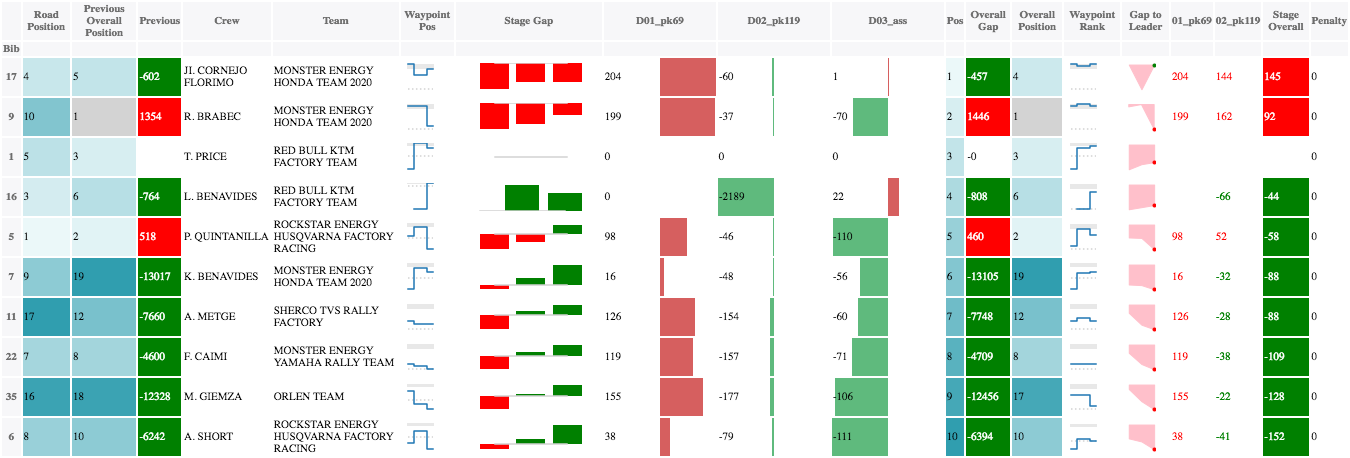

In [362]:
from IPython.display import Image
Image(img)